In [1]:
###################################################################
# Built-in modules ################################################
###################################################################
import sys
import os

sys.path.append("../../")

import numpy as np
import imp
import cv2
import os
import matplotlib.pyplot as plt
import gc

import math
import time
import glob

###################################################################
# Custom modules ##################################################
###################################################################

from components.matchers.NumbaPatchMatcher import Wrapper as m
from components.utils.SimpleProgressBar import SimpleProgressBar
from components.utils import utils as u
from components.utils import plot_utils as plu
from components.utils.CSVWriter2 import Wrapper as csv
from components.utils.Metrix import Wrapper as me

###################################################################
# Dataset specific modules#########################################
###################################################################

from components.utils import middlebury_utils as mbu


In [2]:
ROOT_PATH = os.path.join("..", "..")
EXPERIMENT_TITLE = "ALG_005_EXP_008-PatchMatch-MacLean_et_al-Numba-normlised_images-rgb"

INIT_METHOD = "maclean"
DATASET = "middlebury"

DATASET_FOLDER = os.path.join(ROOT_PATH, "datasets", DATASET)
LOG_FOLDER = os.path.join(ROOT_PATH, "experiments", "logs")
CSV_FILEPATH = os.path.join(LOG_FOLDER, EXPERIMENT_TITLE+".csv")
IMG_RES = "450X375"
PREPROCESSING_METHOD = "None"
KERNEL_SIZE = 1
KERNEL_SPEC = "None"

SCENES = ["teddy", "cones"]
SIZE=""
YEAR= 2003
EXP_PARAMS = dict()

#  Loading the dataset and visualising the results

['im2.png', 'im6.png', 'disp2.png', 'teddy_nonocc.png']
..\..\datasets\middlebury\middlebury_2003\teddy\im2.png
..\..\datasets\middlebury\middlebury_2003\teddy\im6.png
..\..\datasets\middlebury\middlebury_2003\teddy\disp2.png
..\..\datasets\middlebury\middlebury_2003\teddy\teddy_nonocc.png
['im2.png', 'im6.png', 'disp2.png', 'cones_nonocc.png']
..\..\datasets\middlebury\middlebury_2003\cones\im2.png
..\..\datasets\middlebury\middlebury_2003\cones\im6.png
..\..\datasets\middlebury\middlebury_2003\cones\disp2.png
..\..\datasets\middlebury\middlebury_2003\cones\cones_nonocc.png


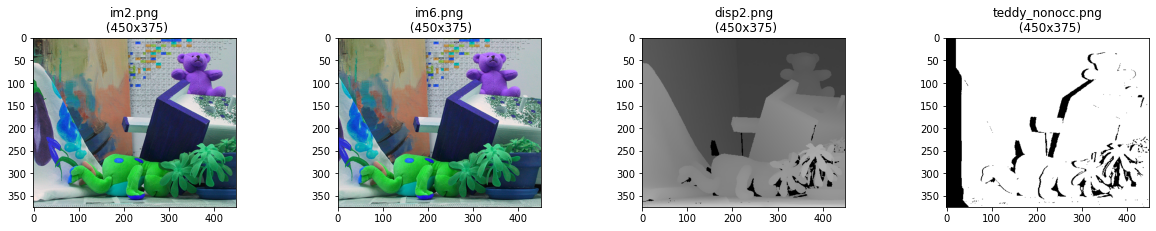

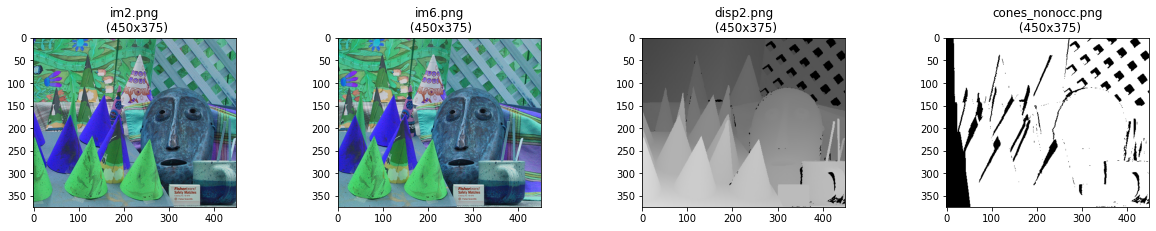

In [3]:
loaded_imgs_and_paths = list(mbu.get_images(DATASET_FOLDER, YEAR, scene, grayscale=False) for scene in SCENES)

for im, path in loaded_imgs_and_paths:
    filenames = list(os.path.split(p)[-1] for p in path)
    plu.plot_images(im, filenames)

# Benchmarking and evaluation

In [4]:
###################################################################
# Initialising hyperparameters and matcher#####################
###################################################################

csv_logger = csv(CSV_FILEPATH, default_header=False)
csv_logger.set_header_function(csv_logger.get_header_v3)
csv_logger.write_csv_header()
csv_logger.set_line_function(csv.format_stereo_matching_results_v2)

MATCH = 30/255
GAP = -20/255
EGAP = -1/255


EXP_PARAMS = {"experiment_id":EXPERIMENT_TITLE, "match": MATCH,"gap":GAP,"egap":EGAP,\
                  "algo":str(m.__module__), "init_method":"default","dataset":DATASET,\
                  "preprocessing_method":"None","kernel_size":1,"kernel_spec":"None"}

File ..\..\experiments\logs\ALG_005_EXP_008-PatchMatch-MacLean_et_al-Numba-normlised_images-rgb.csv already exists, header has not been written.


In [5]:
###################################################################
# Matching ####################################################
###################################################################

results = []

EXP_PARAMS["init_method"] = "maclean_et_al"

patches = [
           np.ones((5,3)), np.ones((7,3)),
           np.ones((9,3)), np.ones((11,3)),
           np.ones((13,3)), np.ones((15,3))
          ]

matcher = m(MATCH, GAP, EGAP)
progress_bar = SimpleProgressBar.get_instance()

progress_counter = 1
steps_to_be_taken = len(SCENES)*len(patches)*4


SAVE_PATH  = os.path.join(ROOT_PATH, "experiments", "disparities", EXPERIMENT_TITLE)

saved_image_names = []
results = []

In [6]:
for match_value in range(10,40, 10):
    for p in patches:
        for i, scene in enumerate(SCENES):
            EXP_PARAMS["match"] = MATCH = match_value/255
            matcher = m(MATCH, GAP, EGAP)
            
            EXP_PARAMS["scene"] = scene
            EXP_PARAMS["image_filename"] = IMAGE_FILENAME = loaded_imgs_and_paths[i][1][0]
            EXP_PARAMS["img_res"] = "{0}x{1}".format(loaded_imgs_and_paths[i][0][1].shape[1], loaded_imgs_and_paths[i][0][1].shape[0])  
            EXP_PARAMS["kernel_size"] = "{0}x{1}".format(p.shape[0], p.shape[1])

            occ = loaded_imgs_and_paths[i][0][3][:,:,0]
            gt = loaded_imgs_and_paths[i][0][2][:,:,0]
            
            left = loaded_imgs_and_paths[i][0][0].astype(np.float64)/255
            right = loaded_imgs_and_paths[i][0][1].astype(np.float64)/255
            disps=[]
            
            tic = time.time()
                
            for ch in range(0,3):
            
                matcher.set_images(left[:,:,i], right[:,:,i])

                matcher.configure_instance()
                matcher.set_filter(p)


                x,raw_disp_map = matcher.test_pipeline()
                disps.append(raw_disp_map)
            
            toc = time.time()
            
            EXP_PARAMS["runtime"] = toc-tic
            
            disps = np.array(disps)
            disp = (disps[0] + disps[1] +disps[2])/3
            disp = 4*disp
            
            temp_path = u.save_disparity(SAVE_PATH, disp)
            saved_image_names.append(os.path.split(temp_path)[-1])
        
            EXP_PARAMS["image_filename"] = temp_path

            EXP_PARAMS["are_occlusions_errors"] = ARE_OCCLUSIONS_ERRORS = False

            EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
            BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, occ, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

            csv_logger.append_new_sm_results(EXP_PARAMS, selected_keys=csv.get_header_v3())

            EXP_PARAMS["are_occlusions_errors"]  = True
            EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
            BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, gt, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

            csv_logger.append_new_sm_results(EXP_PARAMS, selected_keys=csv.get_header_v3())
            results.append(disp)

            progress_bar.progress_bar(progress_counter, steps_to_be_taken, header= "Experiment on patch sizes in progress: ", progress_bar_steps=40)
            progress_counter+=1

Experiment on patch sizes in progress:  [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>----------] 75.00 % completed: 36 / 48 steps

In [7]:
SAVE_PATH  = os.path.join(ROOT_PATH, "experiments", "disparities", EXPERIMENT_TITLE)
saved_image_names = []
for result in results:
    temp_path = u.save_disparity(SAVE_PATH, result)
    saved_image_names.append(os.path.split(temp_path)[-1])

In [3]:
import pandas as pd
experiment_log = pd.read_csv(CSV_FILEPATH)
experiment_log.sort_values(by="bad1", inplace=True) 
experiment_log.head(30)

,experiment_id,match,gap,egap,algo,init_method,dataset,scene,image_filename,img_res,...,are_occlusions_errors,abs_error,mse,avg,eucledian,bad1,bad2,bad4,bad8,runtime
237,ALG_005_EXP_008-PatchMatch-MacLean_et_al-Numba...,0.117647,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_008-...,450x375,...,False,1117404.0,762.179731,7.763740,10473.656477,0.425872,0.252150,0.142226,0.089581,137.412195
233,ALG_005_EXP_008-PatchMatch-MacLean_et_al-Numba...,0.117647,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_008-...,450x375,...,False,1101662.0,749.626002,7.654364,10387.043468,0.426400,0.252665,0.141434,0.087802,153.229884
229,ALG_005_EXP_008-PatchMatch-MacLean_et_al-Numba...,0.117647,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_008-...,450x375,...,False,1087790.0,741.665356,7.557981,10331.743706,0.427553,0.254471,0.141024,0.085579,153.908308
225,ALG_005_EXP_008-PatchMatch-MacLean_et_al-Numba...,0.117647,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_008-...,450x375,...,False,1093514.0,743.755541,7.597752,10346.292089,0.432875,0.261468,0.146033,0.085655,149.648268
221,ALG_005_EXP_008-PatchMatch-MacLean_et_al-Numba...,0.117647,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_008-...,450x375,...,False,1103468.0,739.926573,7.666912,10319.625575,0.442040,0.272473,0.156407,0.091068,138.722857
217,ALG_005_EXP_008-PatchMatch-MacLean_et_al-Numba...,0.117647,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_008-...,450x375,...,False,1123810.0,753.197449,7.808249,10411.757585,0.447681,0.276837,0.158116,0.092985,202.804486
209,ALG_005_EXP_008-PatchMatch-MacLean_et_al-Numba...,0.078431,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_008-...,450x375,...,False,1233294.0,884.460070,8.568945,11282.588356,0.474744,0.312216,0.171540,0.089365,145.901117
213,ALG_005_EXP_008-PatchMatch-MacLean_et_al-Numba...,0.078431,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_008-...,450x375,...,False,1269614.0,919.506080,8.821297,11503.948540,0.475362,0.313675,0.175048,0.092964,158.184157
205,ALG_005_EXP_008-PatchMatch-MacLean_et_al-Numba...,0.078431,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_008-...,450x375,...,False,1218836.0,873.134472,8.468491,11210.118287,0.478531,0.316579,0.172568,0.088372,138.357192
201,ALG_005_EXP_008-PatchMatch-MacLean_et_al-Numba...,0.078431,-0.078431,-0.003922,components.matchers.NumbaPatchMatcher,maclean_et_al,middlebury,cones,..\..\experiments\disparities\ALG_005_EXP_008-...,450x375,...,False,1203704.0,853.023470,8.363353,11080.264257,0.481643,0.319352,0.172165,0.086878,130.579408


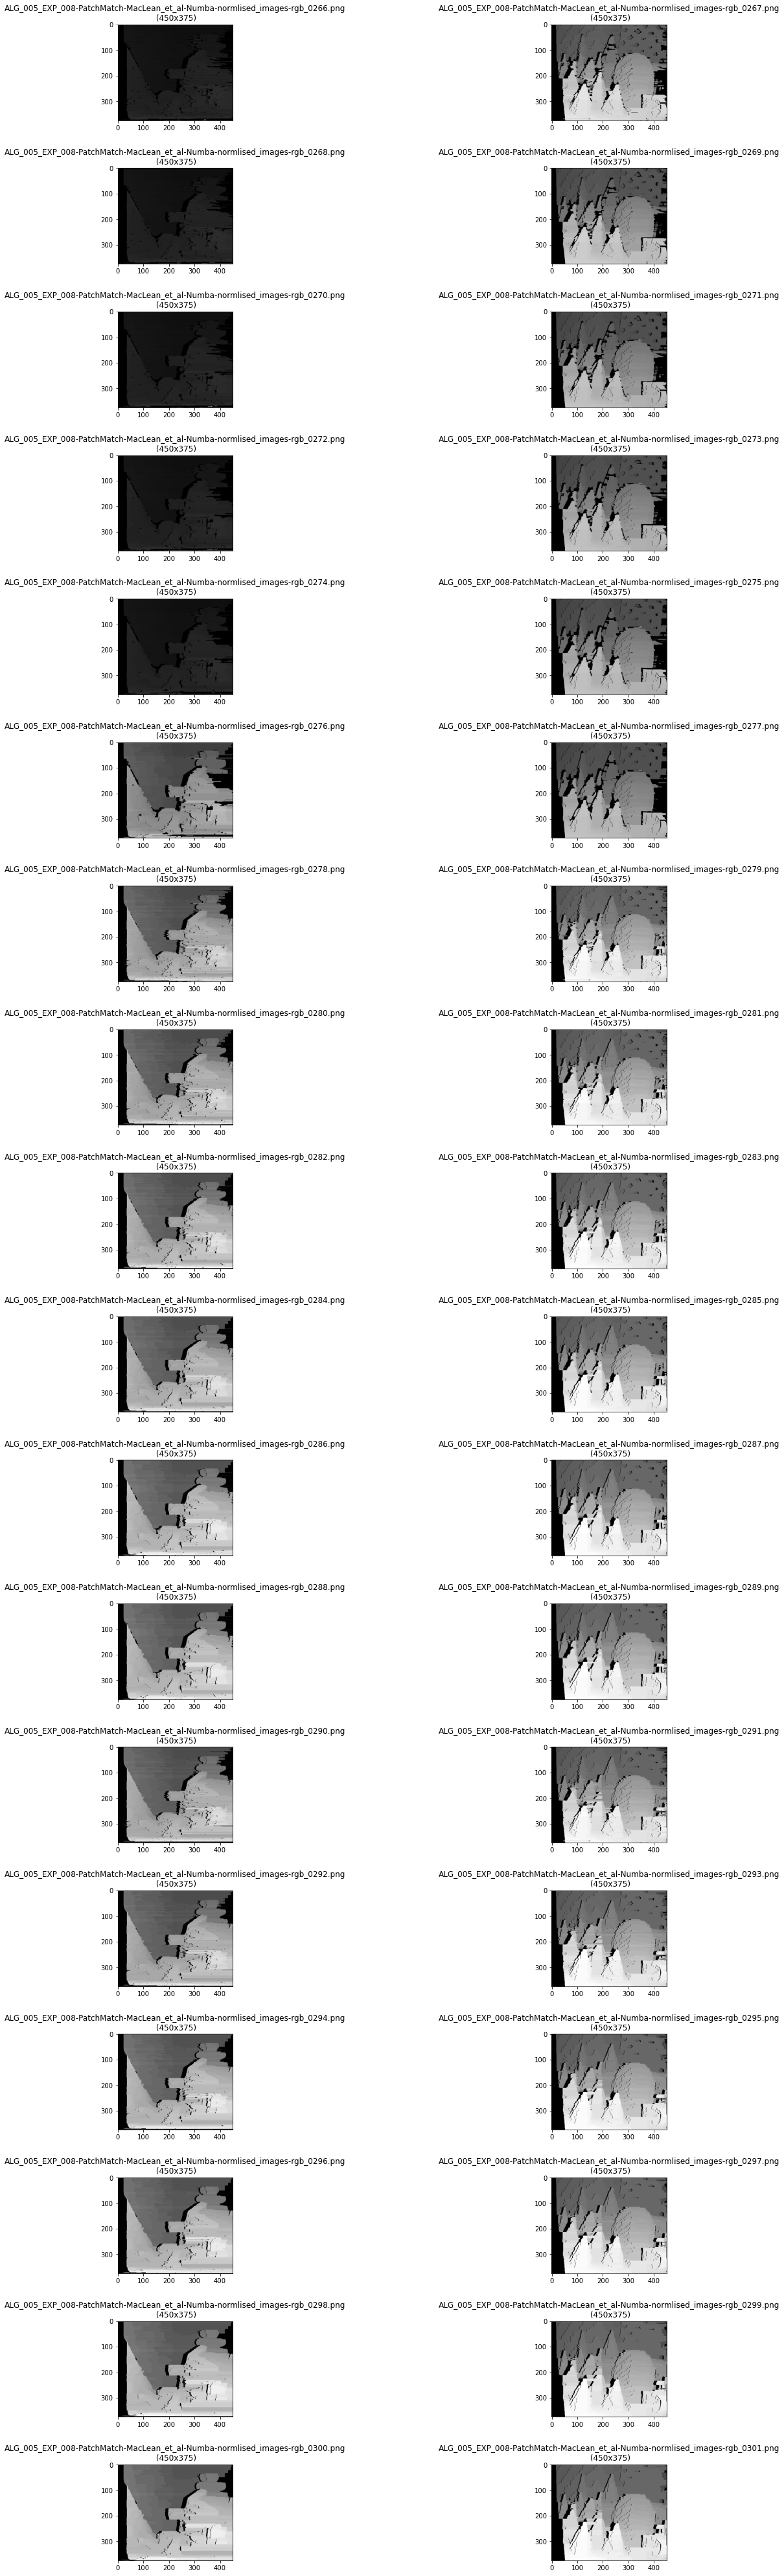

In [9]:
plu.plot_images(results, saved_image_names, ncols=2)